In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [12]:
import pandas as pd
from utilities_functions.intermediate_layer_extraction import return_layer_input
from utilities_functions.ri_calculator import computeRi
import deepmatcher as dm
import torch

In [5]:
attributes =['Beer_Name','Brew_Factory_Name','Style','ABV']

In [6]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../../models/beer_hybrid.pth')

In [7]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/Beer/'
                                                                         ,'negatives',128,model,
                                                                        model.classifier,device=-1)

In [8]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/Beer',
                                                                       'positives',64,model,
                                                                       model.classifier,device=-1)

In [9]:
attribute_length = int((300*3)/len(attributes))
classifier_length = int(attribute_length*len(attributes))

In [10]:
model = model.cuda()

## Negative analysis

In [23]:
negatives_ri = computeRi(model.classifier,attributes,neg_classifier_inputs,attribute_length,1)

100%|██████████| 128/128 [00:08<00:00, 14.96it/s]


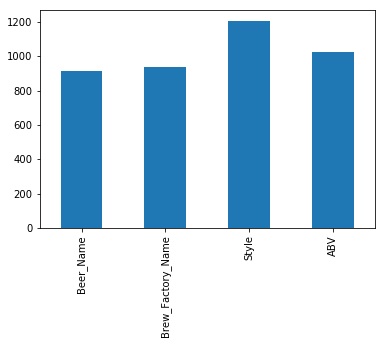

In [24]:
ri_norms_negative_samples = []
for ri_list in negatives_ri:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
negatives_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)
negatives_variation_df.sum().plot.bar()

In [25]:
negatives_variation_df.to_csv('experiment-results/negatives_ri.csv',index=False)

## Positive analysis

In [26]:
positives_ri = computeRi(model.classifier,attributes,pos_classifier_inputs,attribute_length,0)

100%|██████████| 4/4 [00:00<00:00, 16.15it/s]


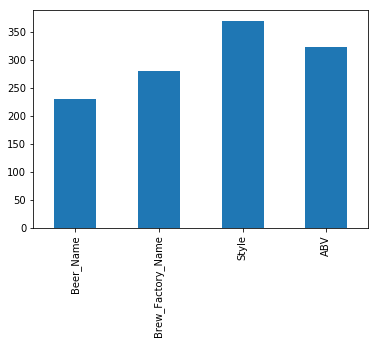

In [27]:
ri_norms_positives = []
for ri_list in positives_ri:
    ri_norms_positives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
positives_variation_df = pd.DataFrame(data= ri_norms_positives,columns=attributes)
positives_variation_df.sum().plot.bar()

In [28]:
positives_variation_df.to_csv('experiment-results/positives_ri_v2.csv',index=False)

## Compute closer vectors

In [30]:
from utilities_functions.distance_measures import calculate_nearest_neighbors_onAttributes

In [43]:
positives_nn = calculate_nearest_neighbors_onAttributes(pos_classifier_inputs,pos_ids,positives_ri,
                                                       neg_classifier_inputs,neg_ids,attributes,attribute_length)

100%|██████████| 4/4 [00:00<00:00, 527.47it/s]


In [45]:
negatives_nn = calculate_nearest_neighbors_onAttributes(neg_classifier_inputs,neg_ids,negatives_ri,
                                                        pos_classifier_inputs,pos_ids,attributes,attribute_length)

100%|██████████| 128/128 [00:00<00:00, 608.30it/s]


In [48]:
positives_nn.to_csv('experiment-results/positives_nn.csv',index=False)
negatives_nn.to_csv('experiment-results/negatives_nn.csv',index=False)

## Test nearest neighbours

In [49]:
!mkdir temp

In [50]:
from utilities_functions.explainer import generateExplanations,analyze_valueDistribution

In [51]:
positives_closer_vectors_df = pd.read_csv("experiment-results/positives_nn.csv")

In [52]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/beer_hybrid.pth')

In [53]:
negatives = pd.read_csv('../../Structured/Beer/negatives.csv')
positives = pd.read_csv('../../Structured/Beer/positives.csv')

In [55]:
top5NN = generateExplanations(positives_closer_vectors_df,8,negatives,"Beer_Name",hybrid_model,
                    "../../Structured/Beer/positives.csv",1)

===>  PREDICT Epoch 5
Finished Epoch 5 || Run Time:    0.2 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The standard true positives are 62
-------------
===>  PREDICT Epoch 5
Finished Epoch 5 || Run Time:    0.2 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : Iron Mike 's Amber Ale | Railway City Iron Spike Amber Ale are 17
------------------
===>  PREDICT Epoch 5
Finished Epoch 5 || Run Time:    0.2 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : Crater Lake Amber Ale | Flathead Lake Dock Start Amber Ale are 25
------------------
===>  PREDICT Epoch 5
Finished Epoch 5 || Run Time:    0.2 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : Inception Series - Runnin ' With The Devil | 18th Street Deal With the Devil Pale Ale a

In [57]:
top5NN = generateExplanations(positives_closer_vectors_df,5,negatives,"Brew_Factory_Name",hybrid_model,
                    "../../Structured/Beer/positives.csv",1)

===>  PREDICT Epoch 5
Finished Epoch 5 || Run Time:    0.2 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The standard true positives are 62
-------------
===>  PREDICT Epoch 5
Finished Epoch 5 || Run Time:    0.2 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : Devil 's Canyon Brewing Company | Pizza Port &#40; Solana Beach &#41; are 59
------------------
===>  PREDICT Epoch 5
Finished Epoch 5 || Run Time:    0.2 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : Ballast Point Brewing Company | &#40; 512 &#41; Brewing Company are 59
------------------
===>  PREDICT Epoch 5
Finished Epoch 5 || Run Time:    0.2 | Load Time:    0.1 || F1:   0.00 | Prec:   0.00 | Rec:   0.00 || Ex/s:   0.00

The new true positives with attribute value : Wild Ride Brewing Co. . | Saimaan Juomatehdas are 60
------------------